# Dueling DQN


## 一、Dueling DQN Introduction
Dueling DQN是 DQN的另一种改进算法，它在传统 DQN 的基础上只进行了微小的改动，但能大幅提升 DQN的表现。

## 二、优势函数

将动作价值函数Q 减去状态价值函数V 的结果定义为优势函数A

$A(s,a)=Q(s,a)-V(s)$

在同一个状态下，所有动作的优势值之和为0 ，因为所
有动作的动作价值的期望就是这个状态的状态价值。

## 三、网络建模

据此，在Dueling DQN中，Q 网络被建模为：

$Q_{\eta,\alpha,\beta}(s,a)=V_{\eta,\alpha}(s)+A_{\eta,\beta}(s,a)$

$V_{\eta,\alpha}(s)$: 状态价值网络

$A_{\eta,\beta}(s,a)$: 该状态下采取不同动作的优势函数，表示采取不同动作的差异性


## 四、参数定义

$\eta$: 状态价值函数和优势函数共享的网络参数，一般用在神经网络中，用来提取特征的前几层

$\alpha, \beta$: 分别为状态价值函数和优势函数的参数

在这样的模型下，我们不再让神经网络直接输出 Q值，
而是训练神经网络的最后几层的两个分支，
分别输出状态价值函数和优势函数，再求和得到Q 值。


<img src="./media/Dueling_DQN_Net.jpg" style="zoom:60%;">

将状态价值函数和优势函数分别建模的好处在于：某些环境下智能体只会关注状态价值，
而并不关心不同动作导致的差异，此时将二者分开建模能够使智能体更好地处理与动作关联较
小的状态。

## 五、代码实现

In [1]:
import random
import gymnasium as gym
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
from tqdm import tqdm
from Qnet import Qnet

In [2]:
class VAnet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_V = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        A = self.fc_A(F.relu(self.fc1(x)))
        V = self.fc_V(F.relu(self.fc1(x)))
        Q = V + A - A.mean(1).view(-1, 1) # Q 值由 V 值和 A 值计算得到
        return Q

In [9]:
class DQN:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, taget_update, device, dqn_type='VanillaDQN'):
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.device = device
        if dqn_type == 'VanillaDQN':
            self.q_net = Qnet(state_dim, hidden_dim, action_dim).to(device)
            self.target_q_net = Qnet(state_dim, hidden_dim, action_dim).to(device)
        elif dqn_type == 'DuelingDQN':
            self.q_net = VAnet(state_dim, hidden_dim, action_dim).to(device)
            self.target_q_net = VAnet(state_dim, hidden_dim, action_dim).to(device)

        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.count = 0
        self.taget_update = taget_update
        self.dqn_type = dqn_type

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)

        if self.dqn_type == 'DoubleDQN':
            max_actions = self.q_net(next_states).argmax(1).view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(1, max_actions)
        else:
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)

        target_q_values = rewards + self.gamma * max_next_q_values * (1 - dones)

        loss = F.mse_loss(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.count += 1
        if self.count % self.taget_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())


In [10]:
lr = 1e-2
num_episodes = 200
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 50
buffer_size = 5000
minimal_size = 1000
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = 11  # 将连续动作分成11个离散动作

In [11]:
def dis_to_con(discrete_action, env, action_dim):  # 离散动作转回连续的函数
    action_lowbound = env.action_space.low[0]  # 连续动作的最小值
    action_upbound = env.action_space.high[0]  # 连续动作的最大值
    return action_lowbound + (discrete_action /
                              (action_dim - 1)) * (action_upbound -
                                                   action_lowbound)

In [12]:
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size,
              batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    for i in range(10):
        with tqdm(total=int(num_episodes / 10),
                  desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state, _ = env.reset()
                terminated, truncated = False, False
                while not (terminated or truncated):
                    action = agent.take_action(state)
                    max_q_value = agent.max_q_value(
                        state) * 0.005 + max_q_value * 0.995  # 平滑处理
                    max_q_value_list.append(max_q_value)  # 保存每个状态的最大Q值
                    action_continuous = dis_to_con(action, env,
                                                   agent.action_dim)
                    next_state, reward, terminated, truncated, _ = env.step([action_continuous])
                    done = terminated or truncated
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(
                            batch_size)
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'next_states': b_ns,
                            'rewards': b_r,
                            'dones': b_d
                        }
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list, max_q_value_list

Iteration 9: 100%|██████████| 20/20 [00:13<00:00,  1.54it/s, episode=200, return=-178.262]


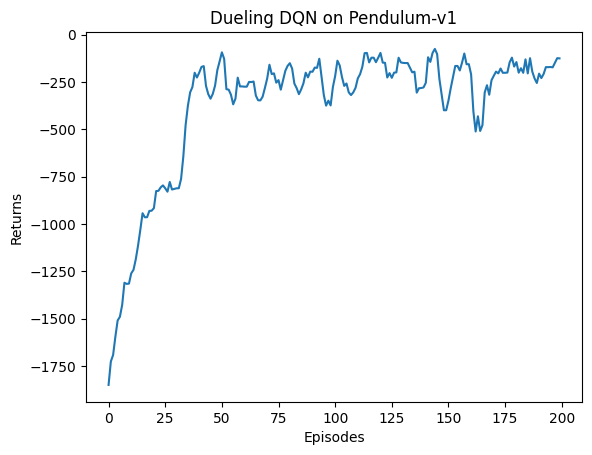

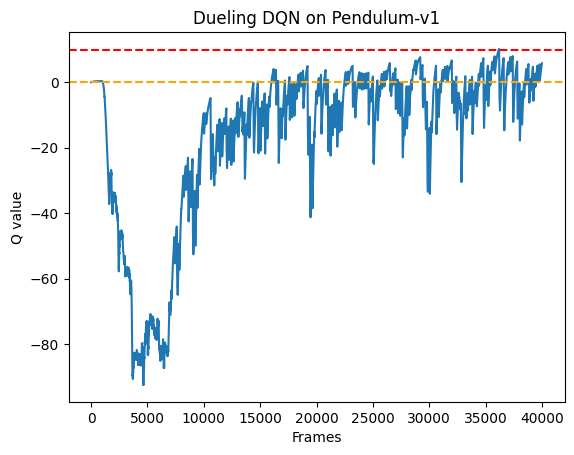

In [13]:
random.seed(0)
np.random.seed(0)
env.reset(seed=0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update,
device, 'DuelingDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer,minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()